In [34]:
import json
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from bio_lib import run_prodigy_jax

def process_pdbs(dataset_path, pdb_folder, output_folder):
    """Process all PDBs and save individual results."""
    with open(dataset_path) as f:
        dataset = json.load(f)
    
    os.makedirs(output_folder, exist_ok=True)
    
    for pdb_id, data in dataset.items():
        try:
            pdb_path = Path(pdb_folder) / f"{pdb_id}.pdb"
            results = run_prodigy_jax.run(
                pdb_path=pdb_path,
                target_chain="A", 
                binder_chain="B"
            )
            results= {k: float(v) if hasattr(v, 'item') else float(v) for k, v in results.to_dict().items()}
            
            output_path = Path(output_folder) / f"{pdb_id}.json"
            with open(output_path, 'w') as f:
                json.dump(results, f, indent=2)
              
        except Exception as e:
            print(f"Error processing {pdb_id}: {str(e)}")

In [ ]:
org_dataset_path = "dataset.json"
PRODIGYdataset_path = "PRODIGYdataset"
benchmark_results_folder = "benchmark_results"
process_pdbs(org_dataset_path, PRODIGYdataset_path, benchmark_results_folder) # was done on a A100 using google colab

In [23]:
      
import json
import pandas as pd

def merge_datasets(original_path: str, computed_path: str, output_path: str):
    # Load both datasets
    with open(original_path) as f:
        original = json.load(f)
    with open(computed_path) as f:
        computed = json.load(f)
    
    # Convert to dataframes
    df_original = pd.DataFrame.from_dict(original, orient='index')
    df_computed = pd.DataFrame.from_dict(computed, orient='index')
    
    # Add suffix to computed columns to avoid conflicts
    df_computed = df_computed.add_suffix('_computed')
    
    # Merge dataframes
    merged_df = pd.merge(
        df_original, 
        df_computed, 
        left_index=True, 
        right_index=True,
        how='left'
    )
    
    # Save merged dataset
    merged_df.to_csv(output_path)
    return merged_df


In [26]:
df = merge_datasets( "/home/alessio/bio_lib/merged_dataset.json", "/home/alessio/dr_sasa_python/data/dataset.json", 'final_dataset.csv')
df

,DG,ba_val,CC,CP,AC,PP,AP,AA,nis_p,nis_a,...,BSA_computed,CC_computed,CP_computed,AC_computed,PP_computed,AP_computed,AA_computed,nis_p_computed,nis_a_computed,nis_c_computed
1XU1,-8.723495,-8.723495,8.0,12.0,21.0,3.0,10.0,16.0,31.555557,47.333336,...,1700,8,12,21,3,10,16,31.76,39.19,29.05
1AVZ,-8.585580,-8.585580,5.0,8.0,9.0,2.0,14.0,10.0,32.500000,45.000000,...,1259,5,8,9,2,14,10,30.60,42.54,26.87
4CPA,-8.600235,-8.600235,0.0,3.0,16.0,5.0,10.0,19.0,40.816326,42.274055,...,1177,0,3,16,5,10,19,47.96,31.67,20.36
2AJF,-10.095436,-10.095436,1.0,8.0,18.0,5.0,19.0,10.0,35.149158,43.450066,...,1704,1,8,18,5,19,10,37.72,35.96,26.32
2FJU,-5.493851,-5.493851,3.0,4.0,6.0,3.0,6.0,18.0,28.980528,47.193588,...,1245,3,4,6,3,6,18,28.97,39.28,31.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1FFW,-4.536710,-4.536710,7.0,2.0,16.0,0.0,2.0,15.0,17.346939,55.612244,...,1170,7,2,16,0,2,15,21.85,44.37,33.77
1E96,-7.127463,-7.127463,4.0,7.0,16.0,4.0,11.0,8.0,26.446281,48.209366,...,1179,4,7,16,4,11,8,28.74,37.16,34.10
2MTA,-7.962352,-7.962352,3.0,3.0,21.0,2.0,11.0,24.0,27.408638,50.166111,...,1461,3,3,21,2,11,24,24.53,45.75,29.72
1BJ1,-11.660767,-11.660767,3.0,8.0,21.0,7.0,22.0,19.0,40.226170,41.680126,...,1731,3,8,21,7,22,19,41.70,35.68,22.61


In [37]:
def create_analysis_plots(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # ba_val Correlation
    ax = axes[0,0]
    ax.scatter(df['ba_val'], df['ba_val_computed'])
    ax.plot([-15, 0], [-15, 0], 'r--')  # Identity line
    ax.set_xlabel('Original ba_val')
    ax.set_ylabel('Computed ba_val')
    ax.set_title('ba_val Correlation')
    
    # Bland-Altman
    ax = axes[0,1]
    mean_ba_val = (df['ba_val'] + df['ba_val_computed']) / 2
    diff_ba_val = df['ba_val'] - df['ba_val_computed']
    ax.scatter(mean_ba_val, diff_ba_val)
    ax.axhline(y=np.mean(diff_ba_val), color='r', linestyle='--')
    ax.set_xlabel('Mean ba_val')
    ax.set_ylabel('Difference (Original - Computed)')
    ax.set_title('Bland-Altman Plot')
    
    # Contact types
    ax = axes[1,0]
    contact_types = ['CC', 'CP', 'AC', 'PP', 'AP', 'AA']
    original = df[contact_types].mean()
    computed = df[[f'{ct}_computed' for ct in contact_types]].mean()
    
    x = np.arange(len(contact_types))
    width = 0.35
    ax.bar(x - width/2, original, width, label='Original')
    ax.bar(x + width/2, computed, width, label='Computed')
    ax.set_xticks(x)
    ax.set_xticklabels(contact_types)
    ax.set_title('Average Contact Types')
    ax.legend()
    
    # NIS boxplot
    ax = axes[1,1]
    nis_types = ['nis_p', 'nis_a', 'nis_c']
    bp_data = []
    labels = []
    for nis in nis_types:
        bp_data.extend([df[nis], df[f'{nis}_computed']])
        labels.extend([f'Original {nis}', f'Computed {nis}'])
    
    ax.boxplot(bp_data)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_title('NIS Distribution')
    
    plt.tight_layout()
    return fig


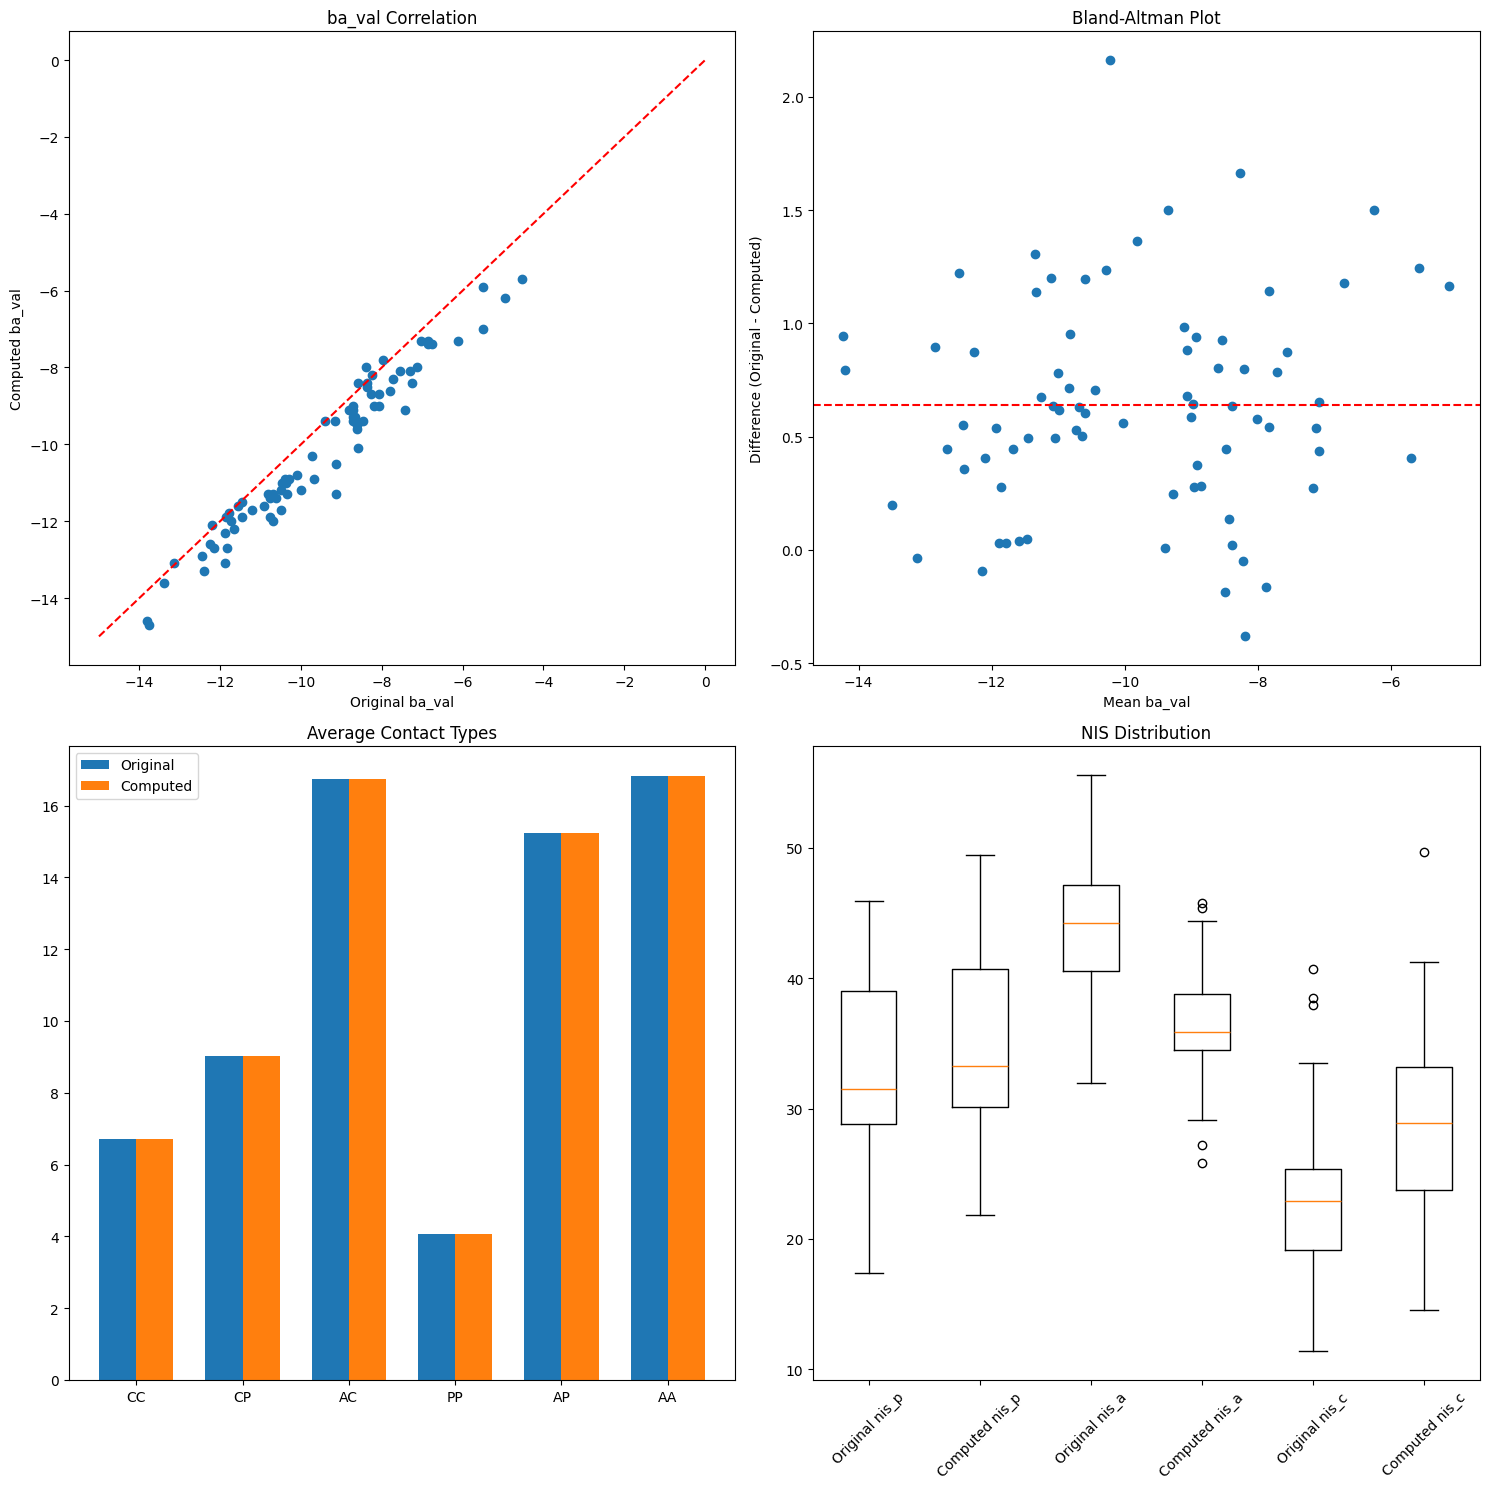

In [38]:
# Usage
df = pd.read_csv('final_dataset.csv')
fig = create_analysis_plots(df)
plt.savefig('analysis_plots.png', dpi=300)